In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import cv2
import math
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [4]:
data_file = np.load('./public_data.npz', allow_pickle=True)

In [7]:
data = data_file["data"]
labels = data_file["labels"]

In [8]:
data.shape, labels.shape

((5200, 96, 96, 3), (5200,))

In [9]:
data[0].dtype

dtype('float32')

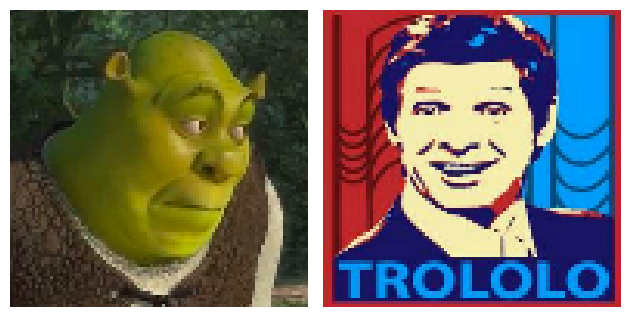

In [10]:
#display shrek and trollolollo
shrek = np.copy(data_file['data'][58])
troll = np.copy(data_file['data'][338])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(shrek.astype(np.uint8))
axes[0].axis('off')
axes[1].imshow(troll.astype(np.uint8))
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [11]:
#filter dataset
num_img = data.shape[0]
shrek_count = 0
troll_count = 0

mask = np.zeros(num_img)

for i in range(num_img):
    if np.array_equal(data[i], shrek):
        mask[i] = 1
        shrek_count += 1 
    if np.array_equal(data[i], troll):
        mask[i] = 2
        troll_count += 1

data = data[mask == 0]
labels = labels[mask == 0]
num_img = data.shape[0]
        
print('Shrek count: ' + str(shrek_count) + "[{:.0%}]".format(shrek_count/num_img))
print('Troll count: ' + str(troll_count) + "[{:.0%}]".format(troll_count/num_img))
print('data size after filtering: ' + str(num_img))

Shrek count: 98[2%]
Troll count: 98[2%]
data size after filtering: 5004


In [12]:
# filter duplicates
data, indexes = np.unique(data, axis=0, return_index=True)
labels = labels[indexes]
duplicates_count = num_img - data.shape[0]
num_img = data.shape[0]
print('duplicates count: ' + str(duplicates_count) + "[{:.0%}]".format(duplicates_count/num_img))
print('data size after filtering duplicates: ' + str(num_img))

duplicates count: 154[3%]
data size after filtering duplicates: 4850


In [ ]:
img_to_show = 400

rows = math.ceil(math.sqrt(img_to_show))
fig_dim = 5 * rows

fig, axes = plt.subplots(rows, rows, figsize=(fig_dim, fig_dim))
for i in range(img_to_show):
    index = np.random.randint(0, num_img)
    #index = 400 + i
    ax = axes[i // rows, i % rows]
    ax.imshow(data[index].astype(np.uint8))
    ax.text(0, 96, index, fontsize=100, color='w', fontweight=1000)
    ax.axis('off')
plt.tight_layout()
plt.show()

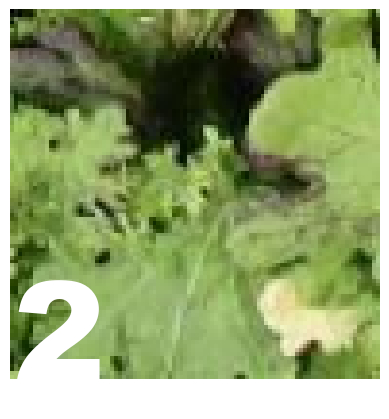

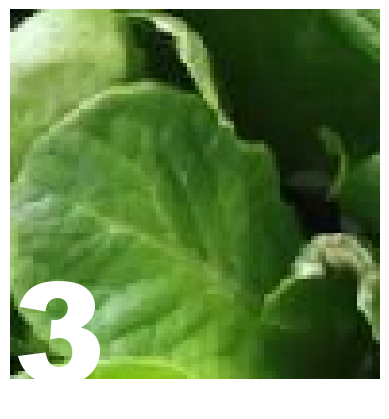

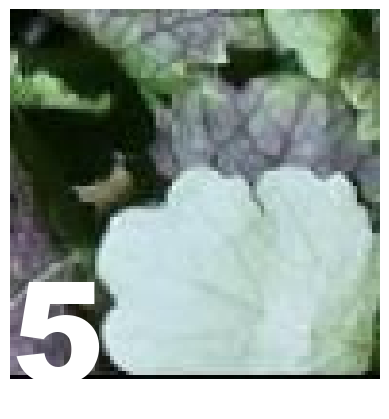

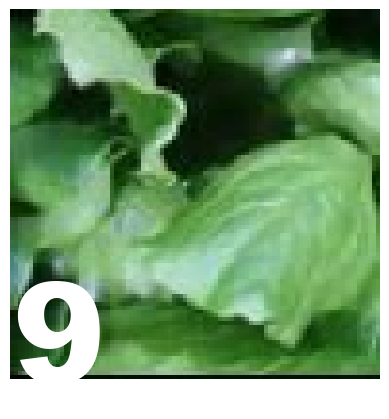

In [15]:
for i in range(num_img):
    if labels[i] == 'unhealthy':
        plt.imshow(data[i].astype(np.uint8))
        plt.text(0, 96, index, fontsize=100, color='w', fontweight=1000)
        plt.axis('off')

In [11]:
#Healthy: 3199,
#Unhealthy: 2001
np.unique(labels, return_counts=True)
y = labels
y[y=="healthy"] = 0
y[y=="unhealthy"] = 1

y = tfk.utils.to_categorical(y, num_classes=2)
y

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data, y, random_state=seed, test_size=0.2, stratify=np.argmax(y,axis=1))
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=np.argmax(y_train_val,axis=1))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (3492, 96, 96, 3), y_train shape: (3492, 2)
X_test shape: (970, 96, 96, 3), y_test shape: (970, 2)
X_val shape: (388, 96, 96, 3), y_val shape: (388, 2)


In [14]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
#tfk.utils.plot_model(mobile, show_shapes=True)

9406464/9406464 [==============================] - 39s 4us/step


In [13]:
mobile.trainable = False

inputs = tfk.Input(shape=(96, 96, 3))
x = mobile(inputs)
outputs = tfkl.Dense(2, activation='softmax')(x)
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

NameError: name 'mobile' is not defined

In [16]:
# Train the model
tl_history = tl_model.fit(
    x = X_train, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 100,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/100
226/226 [==============================] - 100s 426ms/step - loss: 0.5331 - accuracy: 0.7468 - val_loss: 0.4965 - val_accuracy: 0.7830
Epoch 2/100
226/226 [==============================] - 100s 443ms/step - loss: 0.4429 - accuracy: 0.8029 - val_loss: 0.4752 - val_accuracy: 0.7980
Epoch 3/100
226/226 [==============================] - 90s 399ms/step - loss: 0.4082 - accuracy: 0.8107 - val_loss: 0.4991 - val_accuracy: 0.7606
Epoch 4/100
226/226 [==============================] - 87s 387ms/step - loss: 0.3761 - accuracy: 0.8279 - val_loss: 0.4999 - val_accuracy: 0.7781
Epoch 5/100
226/226 [==============================] - 86s 383ms/step - loss: 0.3592 - accuracy: 0.8384 - val_loss: 0.4709 - val_accuracy: 0.8080
Epoch 6/100
226/226 [==============================] - 86s 380ms/step - loss: 0.3466 - accuracy: 0.8390 - val_loss: 0.4757 - val_accuracy: 0.8030
Epoch 7/100
226/226 [==============================] - 86s 379ms/step - loss: 0.3342 - accuracy: 0.8551 - val_loss: 0.5009

In [1]:
# Save the best model
tl_model.save('TransferLearningModel')
del tl_model

NameError: name 'tl_model' is not defined

In [2]:
tl_model = tfk.models.load_model('SubmissionModel/TransferLearningModel')
predictions = tl_model.predict(X_test, verbose=0) > 0.5

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T,
            xticklabels=list(('Healthy', 'Unhealthy')),
            yticklabels=list(('Healthy', 'Unhealthy')),
            cmap='Greens',
            annot=True,
            fmt='g')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

NameError: name 'tfk' is not defined